# Suicide Text Classification

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicide-watch/Suicide_Detection.csv


In [6]:
import re
import string

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import SelectFromModel

from imblearn.pipeline import Pipeline
import pickle


import spacy
nlp = spacy.load("en_core_web_lg")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

https://github.com/jess-data/Twitter-2020-Sentiment-Analysis

## Load & Preview dataset

In [8]:
data = pd.read_csv("../input/suicide-watch/Suicide_Detection.csv")
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [9]:
data.shape

(232074, 3)

In [11]:
#split data for easy training

data_split = np.array_split(data, 20)

df = data_split[0].copy()
df2 = data_split[1].copy()
df3 = data_split[2]
df4 = data_split[3]
df5 = data_split[4]
df6 = data_split[5]

In [12]:
df = df.rename(columns = {"class": "target"})

In [13]:
df.head()

,Unnamed: 0,text,target
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [14]:
df.shape

(11604, 3)

In [15]:
df.target.value_counts()

non-suicide    5878
suicide        5726
Name: target, dtype: int64

<AxesSubplot:>

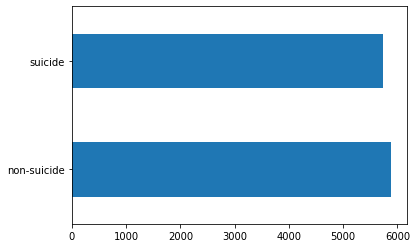

In [16]:
df.target.value_counts().plot.barh()

## Preprocess Text

<img src="https://i.ibb.co/Prrpgxg/nlp-preproc.png" />

In [17]:
class TextPreprocessor(TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
        
    def transform(self, X, *_):
        X_copy = X.copy()
        X_copy[self.text_attribute] = X_copy[self.text_attribute].apply(self._preprocess_text)
        return X_copy
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)
    
    def fit(self, *_):
        return self

In [18]:
text_preprocessor = TextPreprocessor(text_attribute='text')
df_preprocessed = text_preprocessor.transform(df)

## Feature extraction & Split for Train & Test

In [19]:
train, test = train_test_split(df_preprocessed, test_size=0.3)

In [21]:
#Vectorize data

tfidf_vectorizer = TfidfVectorizer(analyzer = "word", max_features=10000)

X_tfidf_train = tfidf_vectorizer.fit_transform(train['text'])
X_tfidf_test = tfidf_vectorizer.transform(test['text'])

In [22]:
y = train['target']
y_test = test['target']

In [23]:
X, y = X_tfidf_train, y
X_test, y_test = X_tfidf_test, y_test

## Feature Scaling

In [26]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X.toarray())
X_test_norm = scaler.transform(X_test.toarray())

## Feature Selection

In [27]:
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_norm, y)
fs = SelectFromModel(lsvc, prefit=True)
X_sel = fs.transform(X_norm)
X_test_sel = fs.transform(X_test_norm)


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [30]:
from IPython.display import Markdown, display

def show_top10_features(classifier, feature_names, categories):
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[0, i])[-100:]
        display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))

In [31]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())
show_top10_features(lsvc, feature_names, lsvc.classes_)

**non-suicide**: aa

**suicide**: aa

In [33]:
print("New dataset shape: ", X_sel.shape)
print("Features reducted: ", X_norm.shape[1] - X_sel.shape[1])

New dataset shape:  (8122, 2833)
Features reducted:  7167


## Predictive Models

In [34]:
# Evaluation matrix 

# this snippet was taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, 
                           class_names, 
                           figsize = (15,15), 
                           fontsize=12,
                           ylabel='True label',
                           xlabel='Predicted label'):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [35]:
def evaluate_model(model, X, y, X_test, y_test, target_names=None):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    print("Accuracy test: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std()))
    
    print("Test classification report: ")
    if target_names is None:
        target_names = model.classes_
    print(classification_report(y_test, model.predict(X_test), target_names=target_names))
    print("Test confusion matrix: ")
    print_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)), class_names=target_names)

## Multinomial Naive Bayes

Accuracy: 0.90 (+/- 0.01)
Accuracy test: 0.86 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.93      0.80      0.86      1774
     suicide       0.82      0.94      0.88      1708

    accuracy                           0.87      3482
   macro avg       0.88      0.87      0.87      3482
weighted avg       0.88      0.87      0.87      3482

Test confusion matrix: 


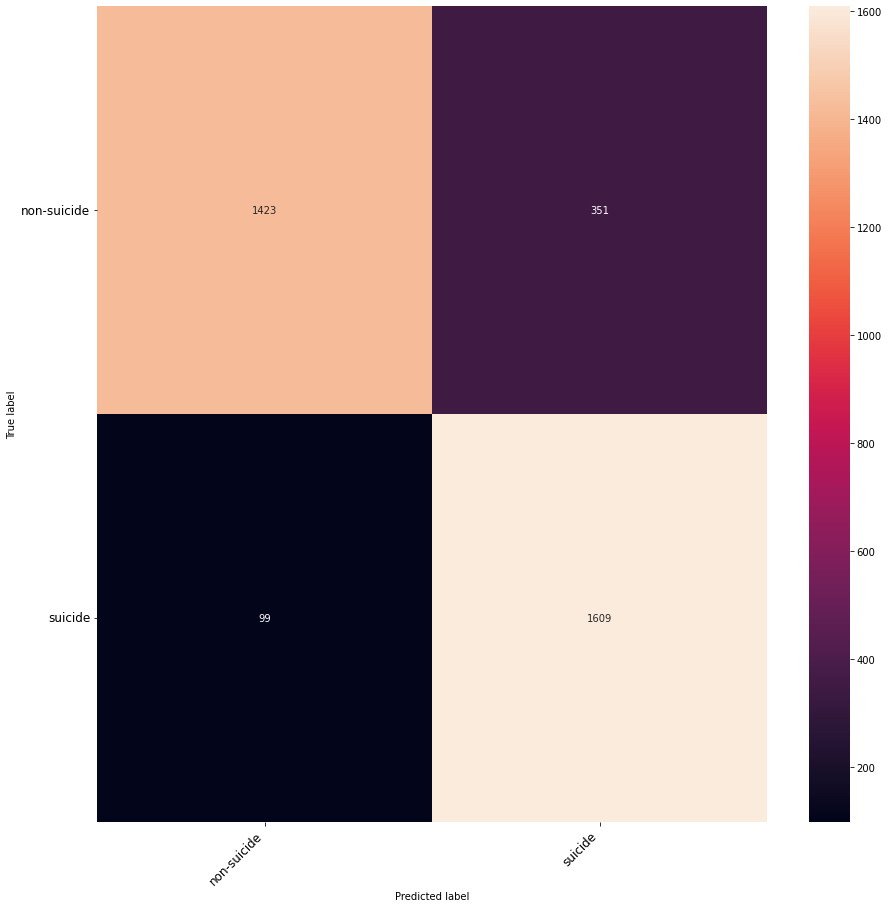

In [37]:
mb = MultinomialNB()
mb.fit(X_sel, y)
evaluate_model(mb, X_sel, y, X_test_sel, y_test)


#save model
pickle.dump(mb, open("MultinomialNB_Text_classification", 'wb')) #90%


## Complement Naive Bayes

Accuracy: 0.90 (+/- 0.01)
Accuracy test: 0.86 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.94      0.80      0.86      1774
     suicide       0.82      0.94      0.88      1708

    accuracy                           0.87      3482
   macro avg       0.88      0.87      0.87      3482
weighted avg       0.88      0.87      0.87      3482

Test confusion matrix: 


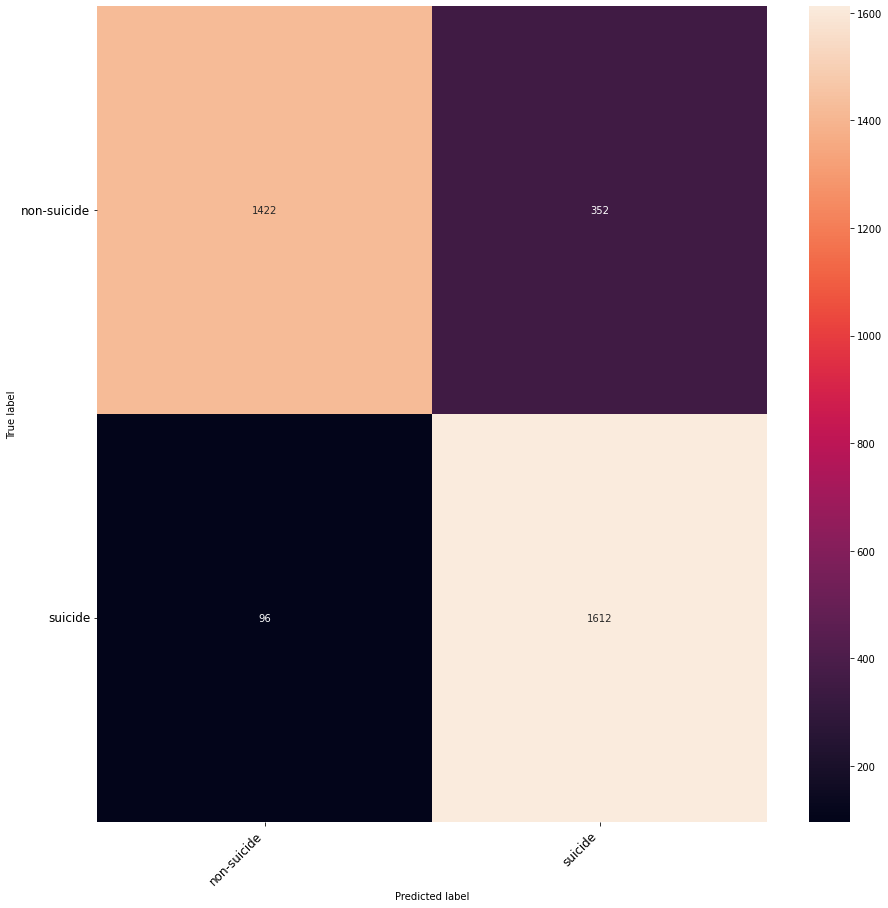

In [38]:
cb = ComplementNB()
cb.fit(X_sel, y)
evaluate_model(cb, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(cb, open("ComplementNB_Text_classification", 'wb')) #90%


## Logistic Regression

Accuracy: 0.92 (+/- 0.01)
Accuracy test: 0.88 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.90      0.91      0.90      1774
     suicide       0.90      0.90      0.90      1708

    accuracy                           0.90      3482
   macro avg       0.90      0.90      0.90      3482
weighted avg       0.90      0.90      0.90      3482

Test confusion matrix: 


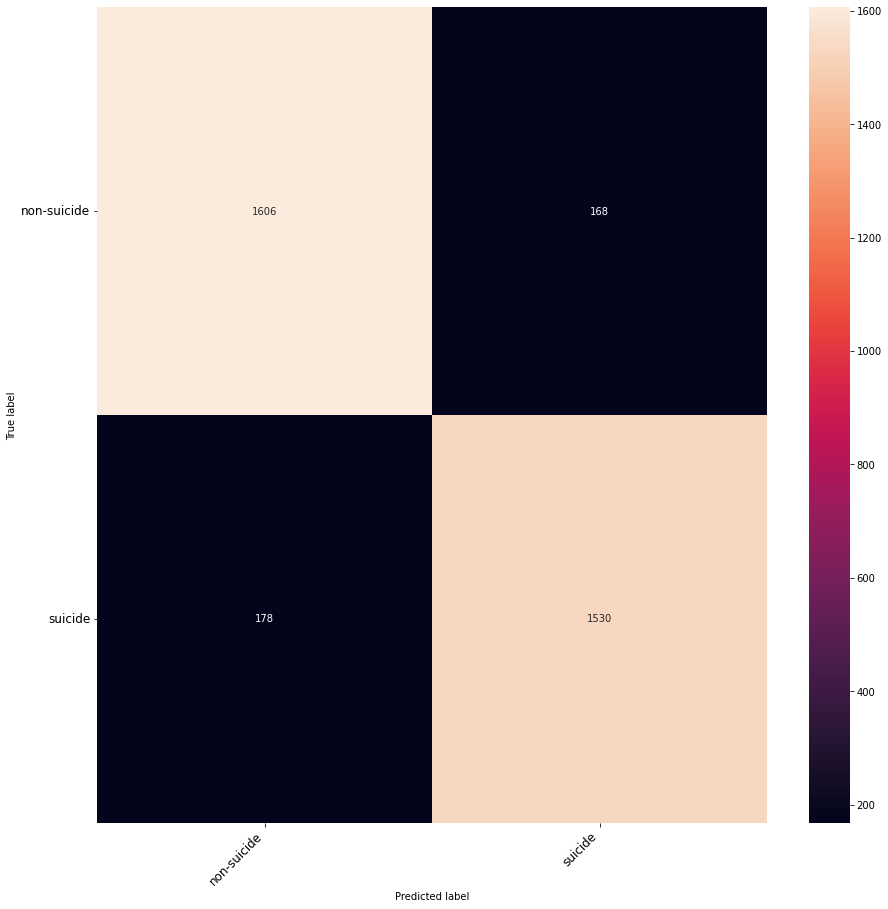

In [39]:
lr = LogisticRegression(multi_class='ovr', solver = 'liblinear', C=10, penalty = 'l2')
lr.fit(X_sel, y)
evaluate_model(lr, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(lr, open("LogisticRegression_Text_classification", 'wb')) #92%


## Linear SVC

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.90 (+/- 0.00)
Accuracy test: 0.83 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.88      0.84      0.86      1774
     suicide       0.84      0.88      0.86      1708

    accuracy                           0.86      3482
   macro avg       0.86      0.86      0.86      3482
weighted avg       0.86      0.86      0.86      3482

Test confusion matrix: 


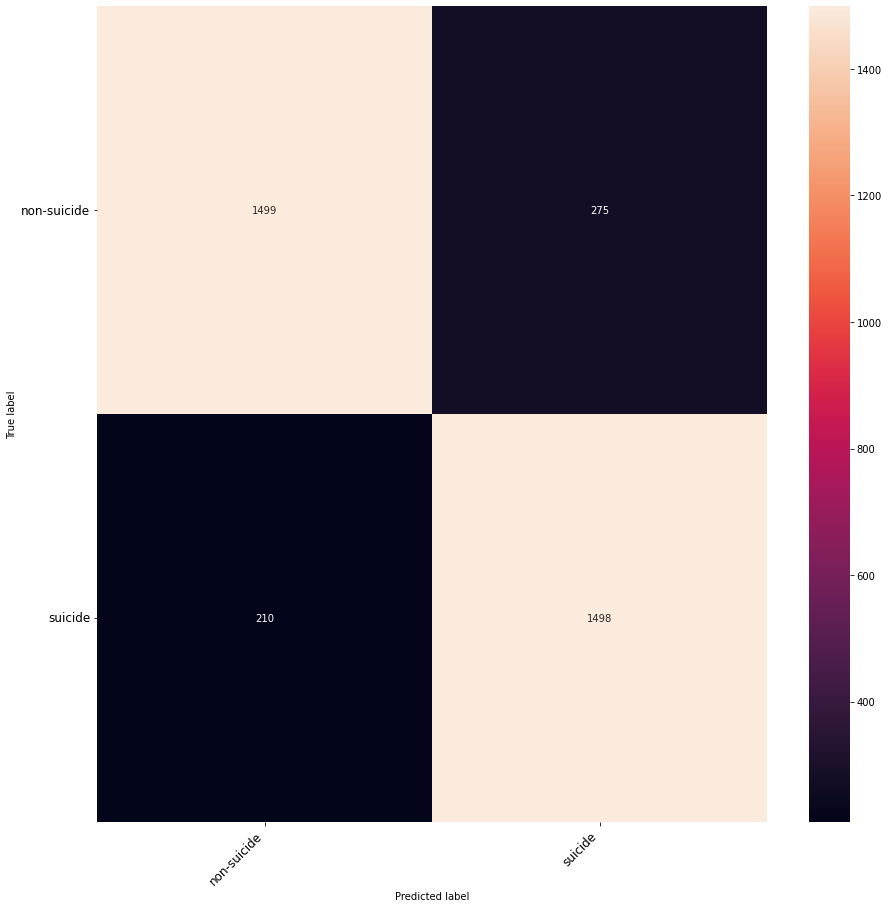

In [40]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_sel, y)
evaluate_model(lsvc, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(lsvc, open("LinearSVC_Text_classification", 'wb')) #90%


## SGDClaccifier

Accuracy: 0.92 (+/- 0.01)
Accuracy test: 0.89 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.91      0.93      0.92      1774
     suicide       0.92      0.90      0.91      1708

    accuracy                           0.91      3482
   macro avg       0.92      0.91      0.91      3482
weighted avg       0.92      0.91      0.91      3482

Test confusion matrix: 


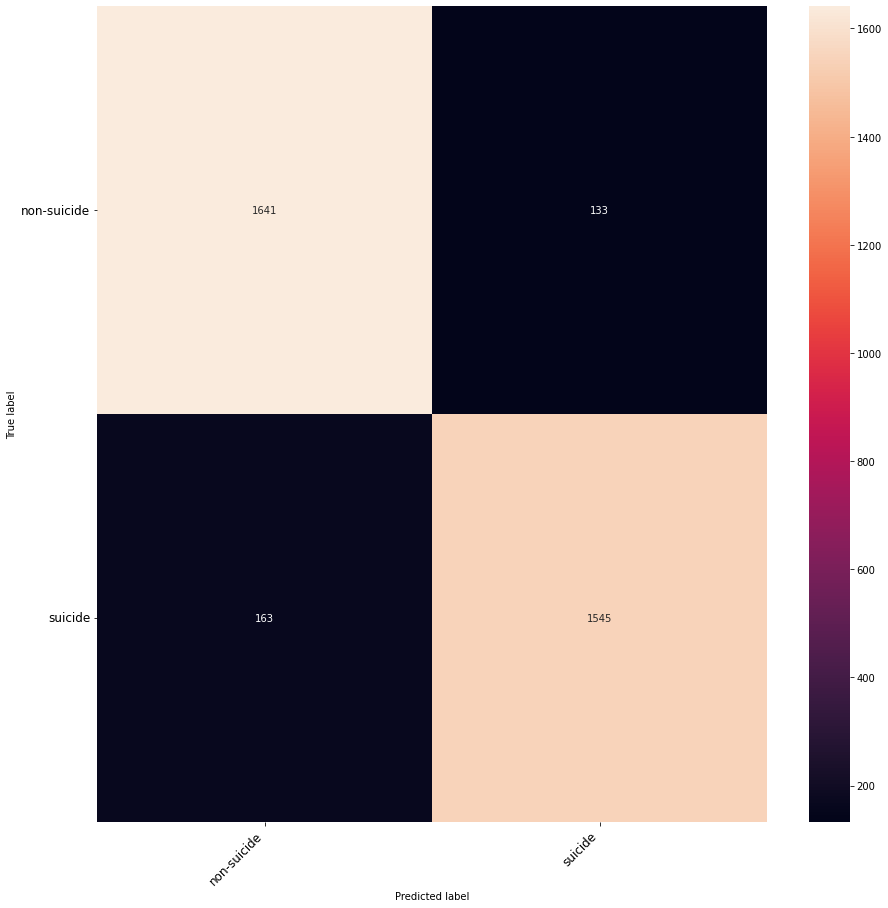

In [41]:
sgd = SGDClassifier(alpha=.0001, max_iter=50, loss='log',
                                       penalty="elasticnet", n_jobs=-1)
sgd.fit(X_sel, y)
evaluate_model(sgd, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(sgd, open("SGDClassifier_Text_classification", 'wb')) #91%

## Soft Voting

Accuracy: 0.93 (+/- 0.01)
Accuracy test: 0.89 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.91      0.92      0.91      1774
     suicide       0.91      0.91      0.91      1708

    accuracy                           0.91      3482
   macro avg       0.91      0.91      0.91      3482
weighted avg       0.91      0.91      0.91      3482

Test confusion matrix: 


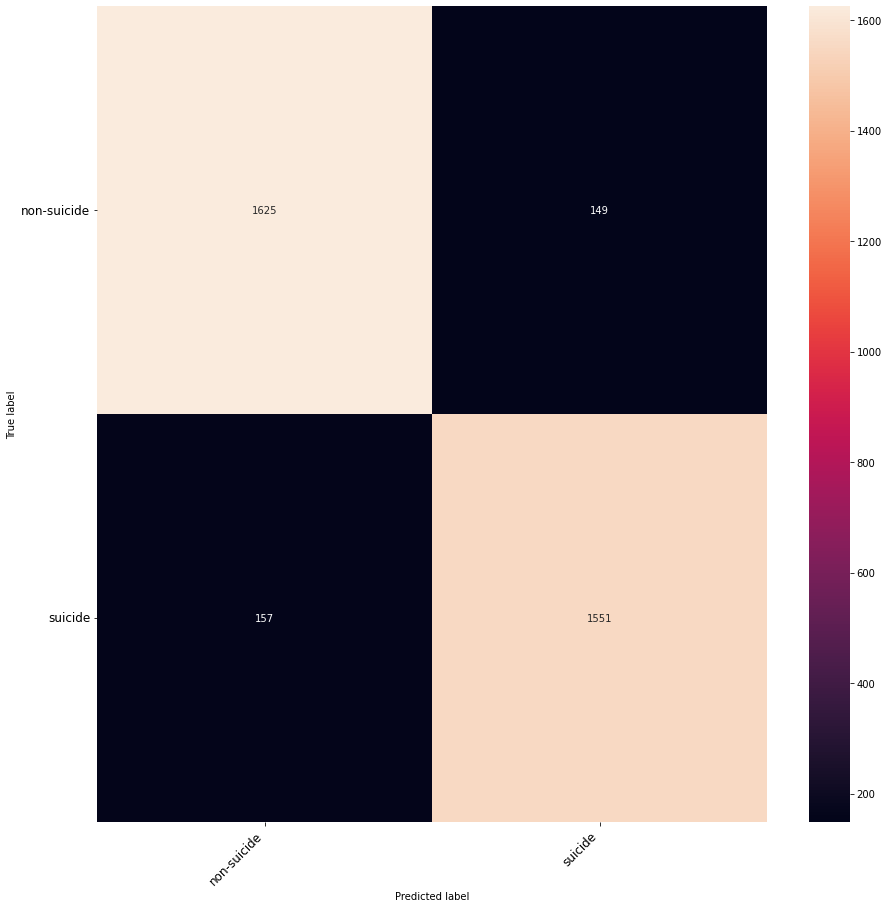

In [42]:
vclf_sgd = VotingClassifier(estimators=[
         ('lr', LogisticRegression(multi_class='ovr', solver = 'liblinear', C=10, penalty = 'l2')),
        ('mb', MultinomialNB()),
        ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"))
], voting='soft', n_jobs=-1)
vclf_sgd.fit(X_sel, y)
evaluate_model(vclf_sgd, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(vclf_sgd, open("VotingClassifier_Text_classification", 'wb')) #93%

# Create Pipeline

In [44]:
# Text Proccessing

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy[self.text_attribute].apply(self._preprocess_text)
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)

In [46]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [62]:
#Pipeline

text_classification_pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor(text_attribute='text')),
    ('vectorizer', TfidfVectorizer(analyzer = "word", max_features=10000)),
    ('todense_converter', DenseTransformer()),
    ('scaler', MinMaxScaler()),
    ('classifier', VotingClassifier(estimators=[
                         ('lr', LogisticRegression(multi_class='ovr', solver = 'liblinear', C=10, penalty = 'l2')),
                        ('mb', MultinomialNB()),
                        ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"))
                        ], 
                                    voting='soft', n_jobs=-1))
     ])

In [63]:
#save Pipeline
from joblib import dump

# dump the pipeline model
dump(pipeline, filename="Suicide_text_classification.joblib")

['Suicide_text_classification.joblib']

### Test Pipeline on other dataset

In [48]:
df2.head()

,Unnamed: 0,text,class
11604,17436,I haven't done or been in remote classes and I...,non-suicide
11605,17437,Let's mess up the billionaires And since we le...,non-suicide
11606,17439,Why do people think every mistake can be fixed...,suicide
11607,17442,"Sweden, a tool to further your political agend...",non-suicide
11608,17444,"My Mother is suicidal and has a plan, not sure...",suicide


In [49]:
train, test = train_test_split(df2, test_size=0.3)

X_p = train.drop(columns=['class', "Unnamed: 0"])
y_p = train['class']

X_p_test = test.drop(columns=['class', "Unnamed: 0"])
y_p_test = test['class']

In [50]:
%%time
pipeline = text_classification_pipeline
pipeline.fit(X_p, y_p)

CPU times: user 3min 49s, sys: 2.28 s, total: 3min 51s
Wall time: 4min 4s


Pipeline(steps=[('text_preprocessor', TextPreprocessor(text_attribute='text')),
                ('vectorizer', TfidfVectorizer(max_features=10000)),
                ('todense_converter',
                 <__main__.DenseTransformer object at 0x7fd173d73410>),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=10,
                                                                  multi_class='ovr',
                                                                  solver='liblinear')),
                                              ('mb', MultinomialNB()),
                                              ('sgd',
                                               SGDClassifier(loss='log',
                                                             max_iter=50,
                                                             penalty='elasticnet'))],
          

In [51]:
%%time
y_pred = pipeline.predict(X_p)

CPU times: user 3min 47s, sys: 1.67 s, total: 3min 49s
Wall time: 3min 48s


In [52]:
%%time
y_test_pred = pipeline.predict(X_p_test)

CPU times: user 1min 35s, sys: 641 ms, total: 1min 36s
Wall time: 1min 35s


In [53]:
y_test_pred

array(['suicide', 'non-suicide', 'non-suicide', ..., 'non-suicide',
       'suicide', 'non-suicide'], dtype=object)

              precision    recall  f1-score   support

 non-suicide       0.99      0.97      0.98      4125
     suicide       0.97      0.99      0.98      3997

    accuracy                           0.98      8122
   macro avg       0.98      0.98      0.98      8122
weighted avg       0.98      0.98      0.98      8122



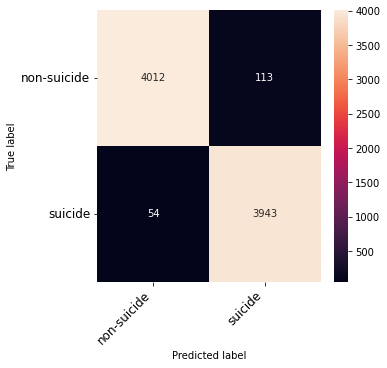

In [54]:
print(classification_report(y_p, y_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_p, y_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

              precision    recall  f1-score   support

 non-suicide       0.92      0.89      0.91      1708
     suicide       0.90      0.93      0.91      1774

    accuracy                           0.91      3482
   macro avg       0.91      0.91      0.91      3482
weighted avg       0.91      0.91      0.91      3482



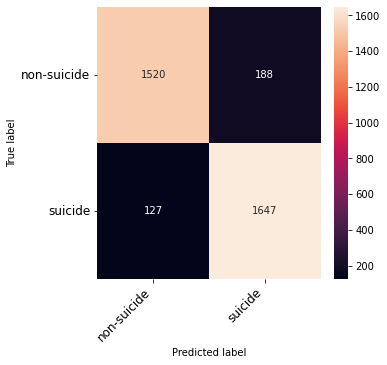

In [55]:
print(classification_report(y_p_test, y_test_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_p_test, y_test_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

In [57]:
#df3 

df3.head()
df_text = df3.drop(columns=['class', "Unnamed: 0"])
df_target = df3["class"]

In [58]:
%%time
y_pred3 = pipeline.predict(df_text)

CPU times: user 5min 28s, sys: 1.47 s, total: 5min 30s
Wall time: 5min 29s


              precision    recall  f1-score   support

 non-suicide       0.93      0.90      0.91      5822
     suicide       0.90      0.93      0.91      5782

    accuracy                           0.91     11604
   macro avg       0.91      0.91      0.91     11604
weighted avg       0.91      0.91      0.91     11604



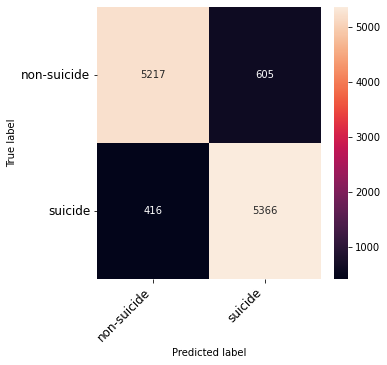

In [59]:
print(classification_report(df_target, y_pred3, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(df_target, y_pred3), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

['Suicide_text_classification.joblib']